<a href="https://colab.research.google.com/github/DK45P3R/TCC2024/blob/main/Scripts/MLP_Treino_Grafico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo MLP


API Calls

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'api_calls_2b.csv'
csv_file_malign = 'api_calls_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Converter rótulos de texto para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_API.h5')
print("Modelo salvo como 'MLP_API.h5'")


<ipython-input-1-374f529157da>:28: ParserWarning: Skipping line 24: expected 5832 fields, saw 6408
Skipping line 34: expected 5832 fields, saw 6695
Skipping line 51: expected 5832 fields, saw 6473
Skipping line 59: expected 5832 fields, saw 7106
Skipping line 88: expected 5832 fields, saw 6695
Skipping line 89: expected 5832 fields, saw 6002
Skipping line 99: expected 5832 fields, saw 5901
Skipping line 108: expected 5832 fields, saw 6002
Skipping line 112: expected 5832 fields, saw 6121
Skipping line 119: expected 5832 fields, saw 6060
Skipping line 126: expected 5832 fields, saw 6277
Skipping line 133: expected 5832 fields, saw 7420

  data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-1-374f529157da>:28: ParserWarning: Skipping line 160: expected 5832 fields, saw 6523
Skipping line 174: expected 5832 fields, saw 5854
Skipping line 175: expected 5832 fields, saw 6475
Skippin

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5815 - loss: 1.3567
Época 1:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5824 - loss: 1.3469 - val_accuracy: 0.7602 - val_loss: 0.5204
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7421 - loss: 0.5165
Época 2:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7423 - loss: 0.5163 - val_accuracy: 0.7679 - val_loss: 0.5047
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7917 - loss: 0.4486
Época 3:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.7920 - loss: 0.4484 - val_accuracy: 0.7934 - val_loss: 0.4732
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8295 - loss: 0.3961
Época 4:
Número de amostras no treino: 1564
Número de amostras no teste: 392


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.81      0.58      0.67       201
     maligno       0.66      0.86      0.75       191

    accuracy                           0.71       392
   macro avg       0.73      0.72      0.71       392
weighted avg       0.74      0.71      0.71       392

Matriz de Confusão:
 [[116  85]
 [ 27 164]]
Modelo salvo como 'MLP_API.h5'


OPCodes

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'opcodes_2b.csv'
csv_file_malign = 'opcodes_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Converter rótulos de texto para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=125, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_Op.h5')
print("Modelo salvo como 'MLP_Op.h5'")


<ipython-input-2-8a65d813b150>:28: ParserWarning: Skipping line 9: expected 197 fields, saw 200
Skipping line 10: expected 197 fields, saw 207
Skipping line 14: expected 197 fields, saw 201
Skipping line 18: expected 197 fields, saw 203
Skipping line 19: expected 197 fields, saw 209
Skipping line 20: expected 197 fields, saw 199
Skipping line 24: expected 197 fields, saw 211
Skipping line 31: expected 197 fields, saw 207
Skipping line 32: expected 197 fields, saw 207
Skipping line 33: expected 197 fields, saw 201
Skipping line 34: expected 197 fields, saw 200
Skipping line 35: expected 197 fields, saw 199
Skipping line 36: expected 197 fields, saw 198
Skipping line 41: expected 197 fields, saw 207
Skipping line 49: expected 197 fields, saw 202
Skipping line 51: expected 197 fields, saw 211
Skipping line 53: expected 197 fields, saw 203
Skipping line 54: expected 197 fields, saw 205
Skipping line 58: expected 197 fields, saw 198
Skipping line 60: expected 197 fields, saw 202
Skipping li

Epoch 1/125


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6388 - loss: 0.7825
Época 1:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6401 - loss: 0.7800 - val_accuracy: 0.6339 - val_loss: 0.6775
Epoch 2/125
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7566 - loss: 0.5119
Época 2:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7574 - loss: 0.5106 - val_accuracy: 0.7188 - val_loss: 0.6194
Epoch 3/125
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8310 - loss: 0.4193
Época 3:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8300 - loss: 0.4201 - val_accuracy: 0.7143 - val_loss: 0.5521
Epoch 4/125
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8165 - loss: 0.4020
Época 4:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.80      0.65      0.72       127
     maligno       0.63      0.78      0.70        97

    accuracy                           0.71       224
   macro avg       0.72      0.72      0.71       224
weighted avg       0.73      0.71      0.71       224

Matriz de Confusão:
 [[83 44]
 [21 76]]
Modelo salvo como 'MLP_Op.h5'


Permissions

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'permissions_2b.csv'
csv_file_malign = 'permissions_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Converter rótulos de texto para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_P.h5')
print("Modelo salvo como 'MLP_P.h5'")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6789 - loss: 0.6009
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6941 - loss: 0.5819 - val_accuracy: 0.9856 - val_loss: 0.1243
Epoch 2/50
41/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 0.1541
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9579 - loss: 0.1420 - val_accuracy: 0.9856 - val_loss: 0.0380
Epoch 3/50
44/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9855 - loss: 0.0492
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9852 - loss: 0.0493 - val_accuracy: 0.9833 - val_loss: 0.0567
Epoch 4/50
44/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9819 - loss: 0.0548
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.97      1.00      0.99       211
     maligno       1.00      0.97      0.99       207

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418

Matriz de Confusão:
 [[211   0]
 [  6 201]]
Modelo salvo como 'MLP_P.h5'


#Grafico

<ipython-input-4-5ec5aafc60fc>:26: ParserWarning: Skipping line 24: expected 5832 fields, saw 6408
Skipping line 34: expected 5832 fields, saw 6695
Skipping line 51: expected 5832 fields, saw 6473
Skipping line 59: expected 5832 fields, saw 7106
Skipping line 88: expected 5832 fields, saw 6695
Skipping line 89: expected 5832 fields, saw 6002
Skipping line 99: expected 5832 fields, saw 5901
Skipping line 108: expected 5832 fields, saw 6002
Skipping line 112: expected 5832 fields, saw 6121
Skipping line 119: expected 5832 fields, saw 6060
Skipping line 126: expected 5832 fields, saw 6277
Skipping line 133: expected 5832 fields, saw 7420

  data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-4-5ec5aafc60fc>:26: ParserWarning: Skipping line 160: expected 5832 fields, saw 6523
Skipping line 174: expected 5832 fields, saw 5854
Skipping line 175: expected 5832 fields, saw 6475
Skippin

Epoch 1/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5770 - loss: 0.7746
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5793 - loss: 0.7701 - val_accuracy: 0.7526 - val_loss: 0.5195
Epoch 2/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7377 - loss: 0.5284
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7377 - loss: 0.5284 - val_accuracy: 0.7628 - val_loss: 0.5022
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7651 - loss: 0.4885
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7652 - loss: 0.4886 - val_accuracy: 0.7526 - val_loss: 0.5269
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7813 - loss: 0.4610
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/4

<ipython-input-4-5ec5aafc60fc>:26: ParserWarning: Skipping line 9: expected 197 fields, saw 200
Skipping line 10: expected 197 fields, saw 207
Skipping line 14: expected 197 fields, saw 201
Skipping line 18: expected 197 fields, saw 203
Skipping line 19: expected 197 fields, saw 209
Skipping line 20: expected 197 fields, saw 199
Skipping line 24: expected 197 fields, saw 211
Skipping line 31: expected 197 fields, saw 207
Skipping line 32: expected 197 fields, saw 207
Skipping line 33: expected 197 fields, saw 201
Skipping line 34: expected 197 fields, saw 200
Skipping line 35: expected 197 fields, saw 199
Skipping line 36: expected 197 fields, saw 198
Skipping line 41: expected 197 fields, saw 207
Skipping line 49: expected 197 fields, saw 202
Skipping line 51: expected 197 fields, saw 211
Skipping line 53: expected 197 fields, saw 203
Skipping line 54: expected 197 fields, saw 205
Skipping line 58: expected 197 fields, saw 198
Skipping line 60: expected 197 fields, saw 202
Skipping li

Modelo salvo como 'MLP_API Calls.h5'
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5383 - loss: 0.7921
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5411 - loss: 0.7883 - val_accuracy: 0.6830 - val_loss: 0.5925
Epoch 2/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7068 - loss: 0.5710
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7079 - loss: 0.5691 - val_accuracy: 0.6964 - val_loss: 0.5666
Epoch 3/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7470 - loss: 0.5061
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7466 - loss: 0.5060 - val_accuracy: 0.6830 - val_loss: 0.5732
Epoch 4/50
24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7774 - loss: 0.4598
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━

Modelo salvo como 'MLP_Opcodes.h5'
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6191 - loss: 0.6737
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6368 - loss: 0.6562 - val_accuracy: 0.9880 - val_loss: 0.1886
Epoch 2/50
42/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9522 - loss: 0.1791
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1692 - val_accuracy: 0.9856 - val_loss: 0.0429
Epoch 3/50
44/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0579
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9853 - loss: 0.0567 - val_accuracy: 0.9856 - val_loss: 0.0276
Epoch 4/50
43/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9920 - loss: 0.0261
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━

Modelo salvo como 'MLP_Permissions.h5'

Relatório de Classificação para API Calls:
              precision    recall  f1-score   support

     benigno       0.81      0.62      0.70       201
     maligno       0.68      0.85      0.76       191

    accuracy                           0.73       392
   macro avg       0.75      0.74      0.73       392
weighted avg       0.75      0.73      0.73       392


Relatório de Classificação para Opcodes:
              precision    recall  f1-score   support

     benigno       0.81      0.72      0.76       127
     maligno       0.68      0.77      0.72        97

    accuracy                           0.75       224
   macro avg       0.74      0.75      0.74       224
weighted avg       0.75      0.75      0.75       224


Relatório de Classificação para Permissions:
              precision    recall  f1-score   support

     benigno       0.97      1.00      0.99       211
     maligno       1.00      0.97      0.99       207

    accurac

<ipython-input-4-5ec5aafc60fc>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['benigno', 'maligno'])
<ipython-input-4-5ec5aafc60fc>:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['benigno', 'maligno'])
<ipython-input-4-5ec5aafc60fc>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['benigno', 'maligno'])
<ipython-input-4-5ec5aafc60fc>:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['benigno', 'maligno'])
<ipython-input-4-5ec5aafc60fc>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks

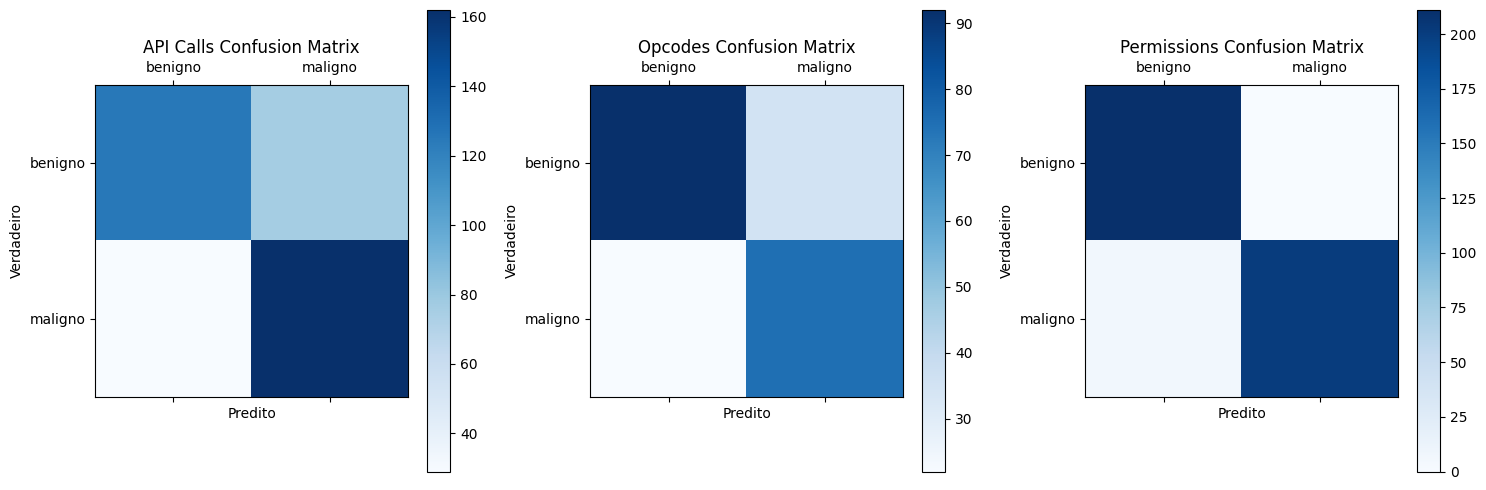

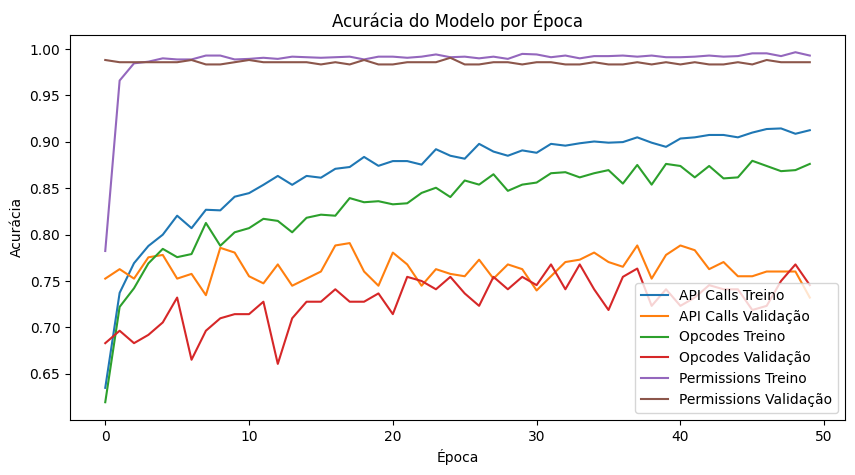

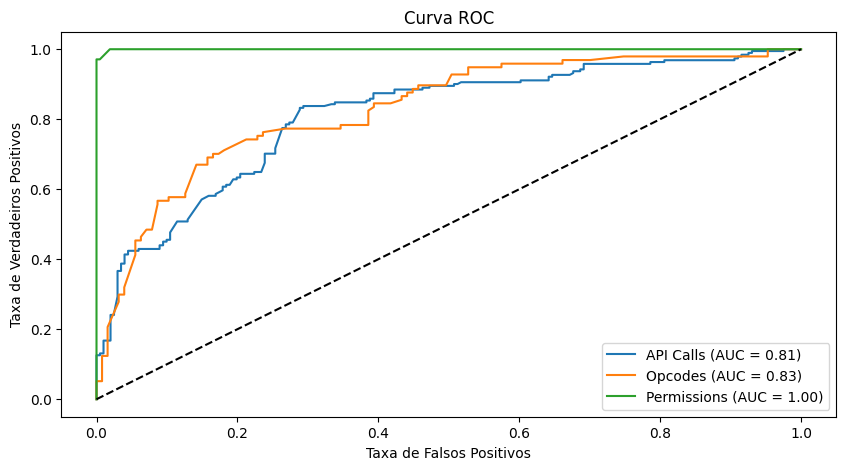

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Função para carregar e preparar os dados
def carregar_dados(csv_file_benign, csv_file_malign):
    num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
    num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
    max_num_cols = max(num_cols_benign, num_cols_malign)

    data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
    data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

    data_benign['classe'] = 'benigno'
    data_malign['classe'] = 'maligno'
    data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)
    data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

    X = data_full.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0)
    y = data_full.iloc[:, -1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    X = X.astype(np.float32)
    y = y.astype(np.int32)

    return X, y

# Função para criar e treinar o modelo MLP
def treinar_modelo(X, y, input_dim, dropout_rate=0.2, epochs=50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    model = Sequential([
        Dense(256, activation='sigmoid', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), callbacks=[print_callback])

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    return y_test_classes, y_pred_classes, y_test, y_pred, model, history

dados = {
    'API Calls': ('api_calls_2b.csv', 'api_calls_2m.csv'),
    'Opcodes': ('opcodes_2b.csv', 'opcodes_2m.csv'),
    'Permissions': ('permissions_2b.csv', 'permissions_2m.csv')
}

classification_reports = []
confusion_matrices = []
histories = []
roc_curves = []

for nome, (csv_b, csv_m) in dados.items():
    X, y = carregar_dados(csv_b, csv_m)
    y_test_classes, y_pred_classes, y_test, y_pred, model, history = treinar_modelo(X, y, input_dim=X.shape[1], epochs=50)
    report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    classification_reports.append((nome, report))
    confusion_matrices.append((nome, conf_matrix))
    histories.append((nome, history))

    # Calcular a curva ROC e AUC para o modelo atual
    fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((nome, fpr, tpr, roc_auc))

    model.save(f'MLP_{nome}.h5')
    print(f"Modelo salvo como 'MLP_{nome}.h5'")

# Exibir os relatórios de classificação
for model_name, report in classification_reports:
    print(f"\nRelatório de Classificação para {model_name}:\n{report}")

# Plotar as matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (model_name, conf_matrix) in zip(axes, confusion_matrices):
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
    ax.set_xticklabels([''] + ['benigno', 'maligno'])
    ax.set_yticklabels([''] + ['benigno', 'maligno'])

plt.tight_layout()
plt.show()

# Plotar os gráficos de precisão (acurácia) ao longo das épocas
plt.figure(figsize=(10, 5))
for model_name, history in histories:
    plt.plot(history.history['accuracy'], label=f'{model_name} Treino')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validação')
plt.title('Acurácia do Modelo por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar as curvas ROC
plt.figure(figsize=(10, 5))
for model_name, fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de chance
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()
